# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
import calendar
import datetime

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#store_data = pd.read_csv('/content/drive/MyDrive/Almabetter learning/Retail Sales Prediction/Rossmann Stores Data.csv')
#stores = pd.read_csv('/content/drive/MyDrive/Almabetter learning/Retail Sales Prediction/store.csv')

store_data = pd.read_csv('Rossmann Stores Data.csv', low_memory = False)
stores = pd.read_csv('store.csv')

In [ ]:
store_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [ ]:
#store_data['StateHoliday'].unique()
#store_data['StateHoliday'] = store_data['StateHoliday'].map({0:'0', 'a':'a', 'b':'b', 'c':'c', '0':'0'})
## Convert date column from object to date


In [ ]:
## Convert the Date column to Datetime
store_data['Date']= pd.to_datetime(store_data['Date'])

## Extract Year and month from Date column
store_data['Year'] = pd.DatetimeIndex(store_data['Date']).year
store_data['Month'] = pd.DatetimeIndex(store_data['Date']).month

In [ ]:
## Displaying the data
store_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,7
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,7
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,7
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,7
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,7


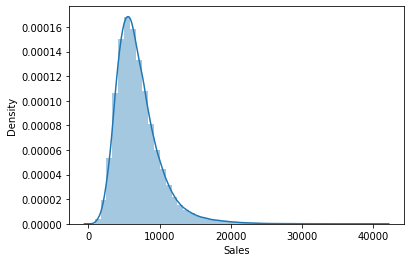

In [ ]:
sns.distplot(store_data[store_data['Sales']!=0]['Sales']);

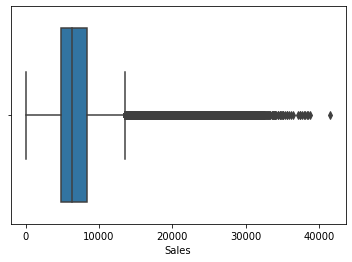

In [ ]:
sns.boxplot(store_data[store_data['Sales']!=0]['Sales']);

In [ ]:
store_data_high_sales=store_data[store_data['Sales']>=20000][['Year','Month','Sales']]

In [ ]:
## See count of high sales/day in certain months to estimate high sales period
pd.pivot_table(data=store_data_high_sales[['Year','Month','Sales']],index='Month',columns='Year',aggfunc='count',fill_value=0)

Sales          
Year   2013 2014 2015
Month                
1        79   78   75
2        86   96   75
3       169  104  124
4       108  148  151
5       130  123  132
6        88  173  186
7       137   83  123
8        97   76    0
9        74   89    0
10       93   73    0
11      111  120    0
12      532  367    0

In [ ]:
## Check total sales monthwise
#Sales_across_years_monthwise=pd.pivot_table(data=store_data[['Year','Month','Sales']],index='Month',columns='Year',aggfunc='sum',fill_value=0)
Sales_across_years_monthwise=pd.pivot_table(data=store_data[['Year','Month','Sales']],index=['Month','Year'],aggfunc='sum',fill_value=0).reset_index()


In [ ]:
Sales_across_years_monthwise.head()

,Month,Year,Sales
0,1,2013,180132207
1,1,2014,187752787
2,1,2015,198843730
3,2,2013,171534275
4,2,2014,178924677


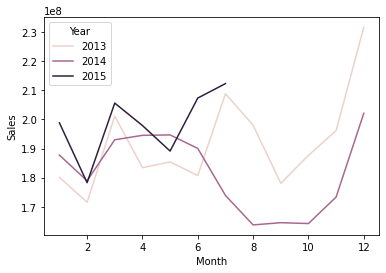

In [ ]:
sns.lineplot(data=Sales_across_years_monthwise,x='Month',y='Sales',hue='Year');

In [ ]:
#Sales_across_years_monthwise['diff21']=Sales_across_years_monthwise[('Sales', 2014)]-Sales_across_years_monthwise[('Sales', 2013)]
#Sales_across_years_monthwise['diff32']=Sales_across_years_monthwise[('Sales', 2015)]-Sales_across_years_monthwise[('Sales', 2014)]
#Sales_across_years_monthwise['diff31']=Sales_across_years_monthwise[('Sales', 2015)]-Sales_across_years_monthwise[('Sales', 2013)]

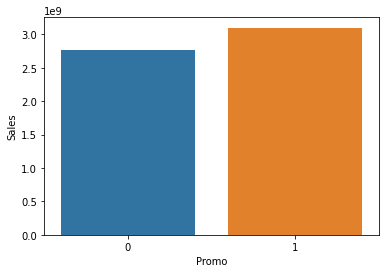

In [ ]:
#store_data['Promo']
sns.barplot(data=pd.pivot_table(data=store_data[['Promo','Sales']],index='Promo',aggfunc='sum',fill_value=0).reset_index(),y='Sales',x='Promo');

In [ ]:
#df_date_sorted_agg=
df_date_sorted_agg=store_data.copy().sort_values(['Date']).groupby('Date')['Sales'].sum()
df_date_sorted_agg

Date
2013-01-01       97235
2013-01-02     6949829
2013-01-03     6347820
2013-01-04     6638954
2013-01-05     5951593
                ...   
2015-07-27    10707292
2015-07-28     9115073
2015-07-29     8499962
2015-07-30     8798854
2015-07-31    10109742
Name: Sales, Length: 942, dtype: int64

In [ ]:
# ## Trying to get a series for plotting agg sales day wise, check any pattern to add varibale like seasonality
# df=df_date_sorted_agg.reset_index()
# df['Sales']=(df['Sales']-df['Sales'].min())/(df['Sales'].max()-df['Sales'].min())
# df.head()

In [ ]:
#Sales_year_month['Year'].unique()

In [ ]:
#### Do we observe any pattern in sales across years, ## No

In [ ]:
#sns.barplot(data=df_test.groupby(['DayOfWeek'])['Sales_x'].sum().reset_index(),x='DayOfWeek',y='Sales_x')  ## Starts with Monday

In [ ]:
## Just to check promo interval values and corresponding Promo2SinceWeek
#stores[stores['PromoInterval']!=0].head()

In [ ]:
stores.shape

(1115, 10)

In [ ]:
stores.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [ ]:
stores[(stores['Promo2']==0) & (stores['Promo2SinceWeek'].isna())].shape

(544, 10)

In [ ]:
stores[stores['CompetitionOpenSinceMonth'].isna()]['Store'].nunique()

354

In [ ]:
## Wherever Promo2 ie continuing and consecutive promotion is zero, implies store didn't participate,
# hence Promo2SinceWeek and Promo2SinceYear should be zero, also there won't be PromoInterval
stores.loc[(stores['Promo2']==0) & (stores['Promo2SinceWeek'].isna()),['Promo2SinceWeek']]=0
stores.loc[(stores['Promo2']==0) & (stores['Promo2SinceYear'].isna()),['Promo2SinceYear','PromoInterval']]=0

In [ ]:
#Impute CompetitionDistance with max distance

stores.loc[stores['CompetitionDistance'].isna()]=stores['CompetitionDistance'].max()

In [ ]:
stores.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    351
CompetitionOpenSinceYear     351
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

In [ ]:
#stores[stores['Promo2SinceYear']!=0]['Promo2SinceYear'].describe()

In [ ]:
## Check the CompetitionOpenSinceYear year range
stores['CompetitionOpenSinceYear'].describe()

count      764.000000
mean      2298.660995
std       4621.710349
min       1900.000000
25%       2006.000000
50%       2010.000000
75%       2013.000000
max      75860.000000
Name: CompetitionOpenSinceYear, dtype: float64

In [ ]:
#stores[~stores['CompetitionOpenSinceYear'].isin([1900,1961])]['CompetitionOpenSinceYear'].min()

In [ ]:
## This is the day since when we have the sales data
store_data['Date'].min()

Timestamp('2013-01-01 00:00:00')

In [ ]:
stores[stores['Promo2SinceYear']!=0]['Promo2SinceYear'].min()

2009.0

In [ ]:
### Not req now, 
## Equivalent code has been written in below cell
### Ref https://www.kaggle.com/shivam017arora/rossmann-sales-prediction-top-1-solution

# competition_open = []
# for index, value in stores[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].iterrows():
#     try:
#         year, month = int(value['CompetitionOpenSinceYear']), int(value['CompetitionOpenSinceMonth'])
#         date = pd.to_datetime("{}-{}-01".format(year, month), format='%Y-%m')
#         competition_open.append(date)
#     except:
#         competition_open.append('1813-01-01') # Added a dummy date, 200 yrs less than min sales date
# stores['CompetitionOpen'] = pd.Series(competition_open)
# stores['CompetitionOpen'] = stores['CompetitionOpen'].dt.strftime('%Y-%m-%d')
# stores['CompetitionOpen']= pd.to_datetime(stores['CompetitionOpen'])
# #stores['CompetitionOpen']=stores['CompetitionOpen'].map(int)
# #stores['CompetitionOpen']=stores['CompetitionOpen'].apply(lambda x:x if x!='2021-10-30' else 0)




# promo = []
# for index, value in stores[['Promo2SinceWeek', 'Promo2SinceYear']].iterrows():
#     try:
#         year, week = int(value['Promo2SinceYear']), int(value['Promo2SinceWeek'])
#         date = pd.to_datetime("{}{}0".format(year, week), format='%Y%W%w')
#         promo.append(date)
#     except:
#         promo.append('1909-01-01')   ## dummy date
# stores['promoYearWeek'] = pd.to_datetime(pd.Series(promo))
# stores['promoYearWeek'] = stores['promoYearWeek'].dt.strftime('%Y%m%d')
# stores['promoYearWeek']= pd.to_datetime(stores['promoYearWeek'])
#stores.loc[stores['promoYearWeek'].isna(),'promoYearWeek'] =0# stores['promoYearWeek'].dt.strftime('%Y%m%d')
#stores['promoYearWeek']=stores['promoYearWeek'].map(int)

In [ ]:
#### calculate difference in number of days for competion and promo
## Function to change data format
def competition_open_yr_mnth(cols):
  try:
    year, month = int(cols[0]), int(cols[1])
    date = pd.to_datetime("{}-{}-01".format(year, month), format='%Y-%m')
    return date
  except:
    return '1813-01-01'  ## Dummy date to identify this data and do transformation afterwards

stores['CompetitionOpen']=stores[['CompetitionOpenSinceYear','CompetitionOpenSinceMonth']].apply(competition_open_yr_mnth,axis=1)
stores['CompetitionOpen']= stores['CompetitionOpen'].dt.strftime('%Y-%m-%d')
stores['CompetitionOpen']= pd.to_datetime(stores['CompetitionOpen'])




def promo_yr_wk(cols):
  try:
    year, week = int(cols[1]), int(cols[0])
    date = pd.to_datetime("{}{}0".format(year, week), format='%Y%W%w')
    return date
  except:
    return '1909-01-01' ## dummy date


stores['promoYearWeek'] =stores[['Promo2SinceWeek', 'Promo2SinceYear']].apply(promo_yr_wk,axis=1)
stores['promoYearWeek'] = stores['promoYearWeek'].dt.strftime('%Y%m%d')
stores['promoYearWeek']= pd.to_datetime(stores['promoYearWeek'])

In [ ]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,promoYearWeek
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2008-09-01,1909-01-01
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01,2010-04-04
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01,2011-04-10
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2009-09-01,1909-01-01
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,2015-04-01,1909-01-01


In [ ]:
# ## Not req

# ## Merge part
# date_test=pd.merge(store_data,stores,on='Store')
# date_test['day_diff_comp']=(date_test['Date']-date_test['CompetitionOpen']).dt.days
# date_test['day_diff_promo']=(date_test['Date']-date_test['promoYearWeek']).dt.days
# date_test.loc[date_test['day_diff_comp']>=73000,'day_diff_comp']=0
# date_test.loc[date_test['day_diff_promo']>=36500,'day_diff_promo']=0

In [ ]:
# ## Not req

# date_test[date_test['promoYearWeek']=='1909-01-01'].shape

In [ ]:
# ## Not req

# date_test[date_test['CompetitionOpen']=='1813-01-01'].shape   #(323348, 22)
# #date_test['day_diff']
# date_test[date_test['day_diff']>=73000].shape

In [ ]:
# ### Not req

# date_test[(date_test['Promo2SinceWeek']==0) & (date_test['Promo2SinceYear']==0)].shape

In [ ]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Store                      1115 non-null   int64         
 1   StoreType                  1115 non-null   object        
 2   Assortment                 1115 non-null   object        
 3   CompetitionDistance        1115 non-null   float64       
 4   CompetitionOpenSinceMonth  764 non-null    float64       
 5   CompetitionOpenSinceYear   764 non-null    float64       
 6   Promo2                     1115 non-null   int64         
 7   Promo2SinceWeek            1115 non-null   float64       
 8   Promo2SinceYear            1115 non-null   float64       
 9   PromoInterval              1115 non-null   object        
 10  CompetitionOpen            1115 non-null   datetime64[ns]
 11  promoYearWeek              1115 non-null   datetime64[ns]
dtypes: dat

In [ ]:
#stores['CompetitionOpen'].astype(int).describe()

In [ ]:
stores.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,promoYearWeek
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2008-09-01,1909-01-01
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01,2010-04-04
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01,2011-04-10
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0,2009-09-01,1909-01-01
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0,2015-04-01,1909-01-01


In [ ]:
## Check the CompetitionOpenSinceMonth values
#stores['CompetitionOpenSinceMonth'].describe() ## 1 to 12
#stores[stores['CompetitionOpenSinceMonth']<=3]

In [ ]:
#stores[stores['CompetitionOpenSinceYear']==1900]

In [ ]:
## For interval, will think afterwards
#join_with = stores['PromoInterval'].str.split(',').apply(pd.Series)
#join_with.columns = join_with.columns.map(lambda x: str(x) + '_PromoInterval')

In [ ]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
 9   Year           1017209 non-null  int64         
 10  Month          1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 85.4+ MB


In [ ]:
store_data_merged=pd.merge(store_data,stores,on='Store')

In [ ]:
## Calculate the number of days since when the promo started
store_data_merged['day_diff_comp']=(store_data_merged['Date']-store_data_merged['CompetitionOpen']).dt.days
store_data_merged['day_diff_promo']=(store_data_merged['Date']-store_data_merged['promoYearWeek']).dt.days

## Identifying the data based on teh dummy dates and changing them to zero
store_data_merged.loc[store_data_merged['day_diff_comp']>=73000,'day_diff_comp']=0
store_data_merged.loc[store_data_merged['day_diff_promo']>=36500,'day_diff_promo']=0

In [ ]:
## Sort data in ascending order of date
store_data_merged=store_data_merged.sort_values(['Date']).reset_index()

In [ ]:
store_data_merged.head()

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,promoYearWeek,day_diff_comp,day_diff_promo
0,1014566,1115,2,2013-01-01,0,0,0,0,a,1,2013,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",1813-01-01,2012-06-03,0,212
1,458921,504,2,2013-01-01,0,0,0,0,a,1,2013,1,c,c,820.0,NaN,NaN,0,0.0,0.0,0,1813-01-01,1909-01-01,0,0
2,924068,1016,2,2013-01-01,0,0,0,0,a,1,2013,1,c,c,550.0,NaN,NaN,1,35.0,2010.0,"Mar,Jun,Sept,Dec",1813-01-01,2010-09-05,0,849
3,220625,243,2,2013-01-01,0,0,0,0,a,1,2013,1,a,a,310.0,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov",1813-01-01,2013-02-10,0,-40
4,2825,3,2,2013-01-01,0,0,0,0,a,1,2013,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2006-12-01,2011-04-10,2223,632


In [ ]:
## Get index of data for last year from March to test
store_data_merged[(store_data_merged['Year']==2015) & (store_data_merged['Month']>=3)].head(2) ## 844431

,index,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionOpen,promoYearWeek,day_diff_comp,day_diff_promo
844431,1094,2,7,2015-03-01,0,0,0,0,0,0,2015,3,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2007-11-01,2010-04-04,2677,1792
844432,507160,558,7,2015-03-01,0,0,0,0,0,0,2015,3,a,a,3000.0,2.0,2010.0,0,0.0,0.0,0,2010-02-01,1909-01-01,1854,0


In [ ]:
170136/len(store_data_merged) ## 16 % of data to test

0.16769321296671388

In [ ]:
store_data_merged.columns

Index(['index', 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'CompetitionOpen', 'promoYearWeek',
       'day_diff_comp', 'day_diff_promo'],
      dtype='object')

In [ ]:
store_data_merged.drop(columns=['index','Date','CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Promo2SinceWeek','Promo2SinceYear','PromoInterval','CompetitionOpen','promoYearWeek'],inplace=True)

In [ ]:
#store_data.drop(columns='Date',inplace=True)
store_data_merged.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,StoreType,Assortment,CompetitionDistance,Promo2,day_diff_comp,day_diff_promo
0,1115,2,0,0,0,0,a,1,2013,1,d,c,5350.0,1,0,212
1,504,2,0,0,0,0,a,1,2013,1,c,c,820.0,0,0,0
2,1016,2,0,0,0,0,a,1,2013,1,c,c,550.0,1,0,849
3,243,2,0,0,0,0,a,1,2013,1,a,a,310.0,1,0,-40
4,3,2,0,0,0,0,a,1,2013,1,a,a,14130.0,1,2223,632


In [ ]:
store_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014567 entries, 0 to 1014566
Data columns (total 16 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Store                1014567 non-null  int64  
 1   DayOfWeek            1014567 non-null  int64  
 2   Sales                1014567 non-null  int64  
 3   Customers            1014567 non-null  int64  
 4   Open                 1014567 non-null  int64  
 5   Promo                1014567 non-null  int64  
 6   StateHoliday         1014567 non-null  object 
 7   SchoolHoliday        1014567 non-null  int64  
 8   Year                 1014567 non-null  int64  
 9   Month                1014567 non-null  int64  
 10  StoreType            1014567 non-null  object 
 11  Assortment           1014567 non-null  object 
 12  CompetitionDistance  1014567 non-null  float64
 13  Promo2               1014567 non-null  int64  
 14  day_diff_comp        1014567 non-null  int64  
 15

In [ ]:
## Convert datatype of CompetitionDistance from 
store_data_merged['CompetitionDistance']=store_data_merged['CompetitionDistance'].astype(int)

In [ ]:
## Encoding Assortment with numerical values
store_data_merged['Assortment']=store_data_merged['Assortment'].apply(lambda x: 1 if x=='a' else (2 if x=='b' else 3))

In [ ]:
## Create Dummy variables for object type data
store_data_final=pd.get_dummies(store_data_merged,drop_first=True)

In [ ]:
## Check presence of null in data
store_data_final.isna().sum().sum()


0

In [ ]:
############ Final Data store_data_final

In [ ]:
## Import libraries for Lin Reg
#from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [ ]:
################################

In [ ]:
## Converting Day of Week to object type
store_data_merged['DayOfWeek']=store_data_merged['DayOfWeek'].astype(object)

Since the Day of Week is in number, a regression model will fit coefficients based on number. So instead of that it can be converted to object type so as to get categories out of it. Our model can then predict based on the categories.

In [ ]:
store_data_final=pd.get_dummies(store_data_merged,drop_first=True)

Here we get the final dataset with all the feature transformations. This data can be put into the machine learning models.

In [ ]:
## Divide data into train and test
## Index based split to test sales for last few months instead of selecting randomly from dataset
store_data_train=store_data_final.iloc[0:844431]
store_data_test=store_data_final.iloc[844431:]

The data had been sorted according to the sales date in ascending order. So the last record represents the latest sales data. Hence, the data has been split into train and test dataset in a way so that we can use the data from last few months to test the accuracy of our model.

In [ ]:
## Separating the target variable from both train and test dataset and converting the dataframe into numpy array.
X_train=store_data_train.drop(['Sales','Store'],axis=1).to_numpy()
y_train=store_data_train['Sales'].to_numpy()

X_test=store_data_test.drop(['Sales','Store'],axis=1).to_numpy()
y_test=store_data_test['Sales'].to_numpy()

In this step the target variable is separated from the independent features. Then it is further converted from DataFrame to numpy array as the regression algorithms accept arrays.

In [ ]:
## Standardisation of data so that it can be used for regression model
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
## Using the paarmeters from Standard scaler to transform test dataset
X_test = scaler.transform(X_test)

The training data is Standardised by invoking the StandardScaler libraray from sklearn and then the fit's parameters is used to transform the test dataset.

In [ ]:
## Test using a simple regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

## fit_intercept=False increases the mse value, so fitting the intercept

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

This is the first elementary model that is being implemented on our dataset.

In [ ]:
print(regressor.intercept_)
reg_coeff=list(regressor.coef_)
print(reg_coeff)

5744.562405927785
[3344.5536676319643, 404.88603663974465, 595.8100791972267, 33.67936187579768, 43.16913881221428, 90.22206646563929, 115.52135520288599, 154.55393341783954, 48.28281608924983, 24.505527050949535, 88.69238470759365, -169.57143406162334, -218.37053004006927, -241.26803742638486, -190.70525458171645, -73.83523419513718, -103.65503517040774, -29.333735248538073, -46.78482693200795, 10.225630001989373, -646.5541482473793, -44.339226551496125, 419.2245703285424]


In [ ]:
# Predict the Train data using model parameters
y_pred_train = regressor.predict(X_train)
# Predict the Test data
y_pred = regressor.predict(X_test)

After fitting the model we predict the target that is Sales for both train and test dataset.

In [ ]:
# Train data performance
print("Mean Square error for training dataset: {:.2f}".format(math.sqrt(mean_squared_error(y_train, y_pred_train))))
# Test data performance
print("Mean Square error for test dataset: {:.2f}".format(math.sqrt(mean_squared_error(y_test, y_pred))))

Mean Square error for training dataset: 1214.88
Mean Square error for test dataset: 1284.44


Mean Square error for test dataset should be more than the tarin datset. 

In [ ]:
## calculate R-square Score for train dataset
print("R2 Score for train dataset: {:.4f}".format(r2_score(y_train, y_pred_train)))

R2 Score for train dataset: 0.8995


We also calculate the R-square value for train datset and find it to be close to 90%.

In [ ]:
## calculate R-square Score for test dataset
r2=r2_score(y_test, y_pred)
print("R2 Score for test dataset: {:.4f}".format(r2))
## Adjusted R square
r2_adj=1-(1-r2)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R-square value for test dataset : {:.4f}".format(r2_adj))

R2 Score for test dataset: 0.8936
Adjusted R-square value for test dataset : 0.8936


Using the predictions on test dataset we calculate the R-square and Adjusted R2-square value.

In [ ]:
# Storing the scors in a list so that it can be compared with scores from other models at the end.
linreg_scores=list([r2,r2_adj])

In [ ]:
# Looking at the Test and predicted data side by side
#pd.DataFrame({'Test': y_test, 'Pred': y_pred})


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

In [ ]:
# Fit a LinearRegression model using cross validation
lm = LinearRegression()
# create a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
for i,j in enumerate(scores):
  print("R-square value after {} iteration: {:.4f}".format(i+1,j))


R-square value after 1 iteration: 0.8983
R-square value after 2 iteration: 0.9002
R-square value after 3 iteration: 0.9010
R-square value after 4 iteration: 0.8994
R-square value after 5 iteration: 0.8987


To better fit our train dataset we use cross validation with five splits and analyze the R-square across each iteration. 

In [ ]:
## We put the KFold with RFE, with number of features as hyper parameter to find optimal no of features and corresponding R-square 
# Define a cross-validation parameters
folds = KFold(n_splits = 5, shuffle = True, random_state = 150)

# Specify range of number of parameters to tune
hyper_params = [{'n_features_to_select': list(range(18, 25))}]


# Perform grid search using Linear regressor
regressor = LinearRegression()
regressor.fit(X_train, y_train)
rfe = RFE(regressor)             

model = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model.fit(X_train, y_train) 

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.4min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=150, shuffle=True),
             error_score=nan,
             estimator=RFE(estimator=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [18, 19, 20, 21, 22, 23,
                                                   24]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

Since this data has lot of features we try to use Recursive feature elimination technique along with Grid search to find optimal number of features that gives us the best R-square value. Here we again split the data into five splits and R-square as teh scoring method.

In [ ]:
# Crossvalidation results
cv_results = pd.DataFrame(model.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.770140,0.030090,0.038124,0.004312,18,{'n_features_to_select': 18},0.899939,0.899322,0.897911,0.899119,0.900116,0.899282,0.000779,7,0.899125,0.899280,0.899633,0.899331,0.899081,0.899290,0.000195
1,3.281975,0.030199,0.039410,0.002665,19,{'n_features_to_select': 19},0.900013,0.899397,0.897972,0.899193,0.900183,0.899352,0.000782,6,0.899194,0.899349,0.899705,0.899400,0.899153,0.899360,0.000196
2,2.707061,0.018269,0.041226,0.008089,20,{'n_features_to_select': 20},0.900052,0.899454,0.898008,0.899245,0.900213,0.899395,0.000781,5,0.899238,0.899389,0.899750,0.899441,0.899199,0.899403,0.000195
3,2.089601,0.013852,0.045017,0.004548,21,{'n_features_to_select': 21},0.900123,0.899533,0.898085,0.899304,0.900284,0.899466,0.000780,4,0.899310,0.899458,0.899820,0.899515,0.899270,0.899475,0.000195
4,1.455163,0.010399,0.038654,0.002449,22,{'n_features_to_select': 22},0.900169,0.899580,0.898130,0.899338,0.900310,0.899506,0.000776,3,0.899348,0.899497,0.899859,0.899557,0.899314,0.899515,0.000194
5,0.787396,0.003479,0.045097,0.006887,23,{'n_features_to_select': 23},0.900171,0.899581,0.898138,0.899339,0.900317,0.899509,0.000775,1,0.899353,0.899501,0.899862,0.899562,0.899317,0.899519,0.000194
6,0.786593,0.010964,0.040436,0.005971,24,{'n_features_to_select': 24},0.900171,0.899581,0.898138,0.899339,0.900317,0.899509,0.000775,1,0.899353,0.899501,0.899862,0.899562,0.899317,0.899519,0.000194


The results of cross validation at each split can be observed at each step. We can see the score it achieved at each cross validation step correspondingg to the number of featurs it selected. The scores obtained on test dataset has been ranked so that we can choose the optimal number of features.

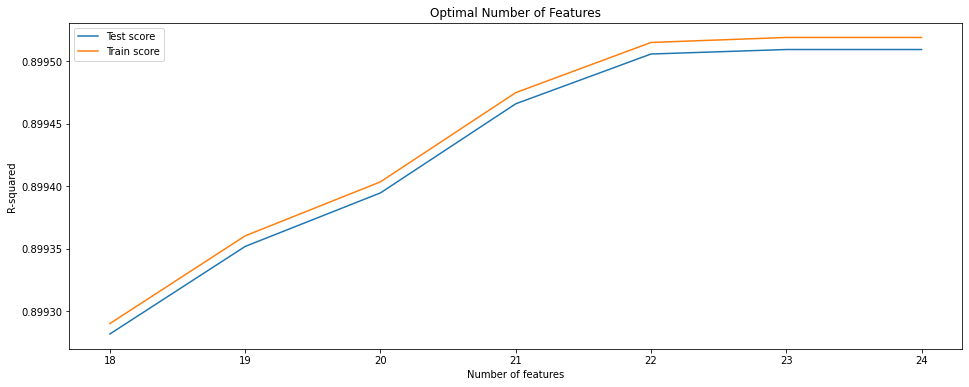

In [ ]:
# Plotting results obtained from cross validation
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('Number of features')
plt.ylabel('R-squared')
plt.title("Optimal Number of Features")
plt.legend(['Test score', 'Train score'], loc='upper left')

*Looking at the table and the above graph we select value for all features as it can be observed that not only the mean fit time is least for that but also the R-square value is highest.*

In [ ]:
# Final model based on all features
n_features_optimal = 24

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# Predict sales of test data
y_pred = lm.predict(X_test)
r2 = r2_score(y_test, y_pred)


## calculate R-square Score for Test dataset
print("R2 Score for test dataset with optimal features: {:.4f}".format(r2))

R2 Score for test dataset with optimal features: 0.8936


Now since we are using all the features the score obtained is the same as the score obtained from Regression model. But this step is important as it gives us information on the fit time and scores for different possible combinations.

Now we test our data using regularized regression models

1.   Lasso Regression
2.   Ridge Regression



1. Lasso Regression

In [ ]:
## Import libraries
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV

In [ ]:
lasso = Lasso()
parameters = {'alpha': [1e-4,1e-3,1e-2,0.05,0.1,1,5,10,20,30,40,50,100,150]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='r2', cv=3)
lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 1, 5, 10, 20,
                                   30, 40, 50, 100, 150]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

In [ ]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("Using ",lasso_regressor.best_params_, " the R-square value is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1}
Using  {'alpha': 1}  the R-square value is:  0.8986273543421758


Here, we are iterating over a set of alphas to find the optimal parameter that gives the best R-square value. With the help of Grid Serach we obtain alpha as 1. We fit our data using Lasso Regression with alpha=1.

In [ ]:
lasso = Lasso(alpha = 1)
lasso.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)
r2_lasso=r2_score(y_test, y_pred_lasso)
print("R-square value for test data using Lasso regression is {:.3f}".format(r2_lasso))

R-square value for test data using Lasso regression is 0.893


We get an R-square value of 0.894 on our test dataset.

In [ ]:
r2_adj_lasso=1-(1-r2_lasso)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("Adjusted R-square value is : {:.3f}.".format(r2_adj_lasso))

Adjusted R-square value is : 0.893.


we further calculate the Adjusted R-square

In [ ]:
lassoreg_scores=list([r2_lasso,r2_adj_lasso])

A list for the scores obtained has been created.

In [ ]:
lasso_coeff=list(lasso.coef_)
print(lasso_coeff)

[3343.1914139966275, 415.2005535618596, 595.7509883102822, 32.997788971195725, 41.937893331282304, 89.25143768600451, 114.74424510362981, 153.49615227922067, 47.09759983052013, 23.48490273281848, 88.5710728428996, -163.2770322109612, -212.09592245656435, -235.0592181240418, -184.50746461244364, -67.79512977406598, -88.96023380257772, -24.99222278079182, -43.48854210995669, 10.980244118860657, -645.7432141390686, -43.390443395422935, 418.67688790858676]


2.  Ridge Regression

In [ ]:
# Hyperprarameter tuning
ridge = Ridge()
parameters = {'alpha': [1e-5,1e-4,1e-3,1e-2,1,5,10,20,30,40,70,100]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='r2', cv=3)
ridge_regressor.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 1, 5, 10, 20, 30,
                                   40, 70, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='r2', verbose=0)

We start with hyper parameter tuning for Ridge regressor. We check with diffrent values of alpha.

In [ ]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("Using ",ridge_regressor.best_params_, " the R-square value is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 100}
Using  {'alpha': 100}  the R-square value is:  0.8985969395336153


We find alpha=100 to be the optimal parameter.

In [ ]:
ridge = Ridge(alpha = 100)
ridge.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)
print("R-square value for test data using ridge regression is {:.3f}".format(r2_score(y_test, y_pred_ridge)))

R-square value for test data using ridge regression is 0.894


Using the optimal alpha we fit our data and predict the test data. We are achieving a score of 0.894 with this.

In [ ]:
ridge_coeff=list(ridge.coef_)

In [ ]:
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_adj_ridge=1-(1-r2)*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))
print("R2 :" ,r2)
print("Adjusted R2 : ",r2_adj_ridge)

R2 : 0.8935922825591887
Adjusted R2 :  0.8935778956993484


The R-square and Adjusted R-square is calculated for Ridge regressor. It can be observed that the values are very close to what we get from Lasso Regression.

In [ ]:
## Store the scores in a list
ridgereg_scores=list([r2_ridge,r2_adj_ridge])

In [ ]:
## Coefficients from different models
df_coeff=pd.DataFrame({'Lin Reg Coeff':reg_coeff,'Lasso Reg Coeff':lasso_coeff,'Ridge Reg Coeff':ridge_coeff},index=store_data_train.drop(['Sales','Store'],axis=1).columns)


The coefficients or the weights that we obtain from diffrent models have been put together at one place to analyze the importace of features corresponding to the models.

In [ ]:
df_coeff

,Lin Reg Coeff,Lasso Reg Coeff,Ridge Reg Coeff
Customers,3344.553668,3343.191414,3343.677277
Open,404.886037,415.200554,404.554088
Promo,595.810079,595.750988,595.851987
SchoolHoliday,33.679362,32.997789,33.676698
Year,43.169139,41.937893,43.166485
Month,90.222066,89.251438,90.247658
Assortment,115.521355,114.744245,115.578568
CompetitionDistance,154.553933,153.496152,154.472989
Promo2,48.282816,47.097600,48.174468
day_diff_comp,24.505527,23.484903,24.496087


**Comparison of coefficients obtained from different Linear Regression models**

---



In [ ]:
pd.DataFrame({'Linear Regr':linreg_scores,'Lasso Regr':lassoreg_scores,'Ridge Regr':ridgereg_scores},index=['R2 Score','Adj R2 Score'])

,Linear Regr,Lasso Regr,Ridge Regr
R2 Score,0.893592,0.893483,0.893587
Adj R2 Score,0.893578,0.893469,0.893578


This dataframe gives us a good comparison of the scores obtained from the diffrent variants of Linear regression models. As it can be seen the scores are almost equivalent. We can select any regression model out of these three to predict our data. Linear regression being a simpler model, we can easily interpret the coefficients and can observe the influence of coefficients on the target. For our model we can see that number of customers, Promo influence the Sales positively. The influence of the day of week can also be observed.





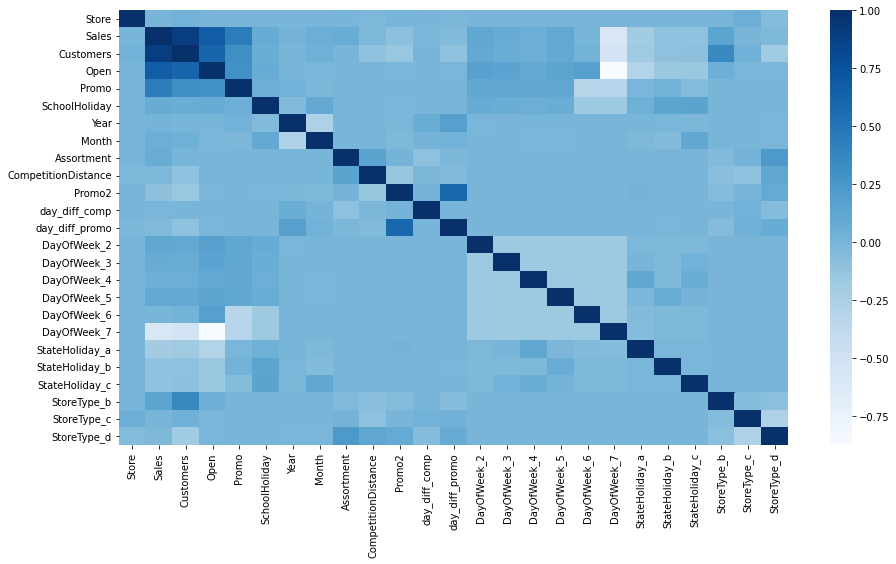

In [ ]:
plt.figure(figsize=(15,8))
sns.heatmap(store_data_train.corr(),cmap="Blues")

In [ ]:
import sklearn

In [ ]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']